## Problem description

Content popularity prediction is very hot topic. Popular content equals greater influence which leads to more sales and so more comission ($). Knowledge about your content to become popular (while its getting popular) may help you make some crucial decisions, too. 

Predicting content popularity may be applied on very different stage of content lifetime. 

Its potential popularity could be measured before content is created ("Lets insert a cat in it!"). That could help designing your content in a way it is very likely to become popular. Tabloids do it, most probably, that is why one can see so many question marks at the end of articles titles.  

Content potential may also be measured after content is created, by looking at audience reaction to the content. One could look at twitter/instragram influencers to see their reaction or other significant events. Yet another way is to focus on content **views over time**. 

This is our task for today. 

We are given a dataset of views registered for different independent content (identified with unique id) over 168h from its creation. 



### Dataset quick inspection 

Lets have a quick look inside the dataset. We are going to use pandas python package as it provides interface similar to R dataframes which is among data scientists. 

In [2]:
import pandas as pd
import numpy as np
views_columns = ['v' + str(i) for i in range(1,169)] 

In [3]:
dataframe = pd.read_csv("data.csv", names = ['id'] + views_columns)

Lets take a look at data frame first few rows and check out the shape of our data frame 

In [4]:
dataframe.head()

,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168
0,341163402640457_880901755333283,0,48059,61152,70036,77636,84999,91436,96926,101260,...,146636,146673,146698,146731,146745,146779,146801,146834,146862,146880
1,341163402640457_880956415327817,41457,82351,121691,162281,202702,241761,278878,314355,347958,...,1947135,1948609,1950140,1951974,1954527,1957281,1961155,1965494,1969985,1974771
2,341163402640457_880993045324154,54229,94312,125887,150893,171727,189382,205866,220667,234427,...,627780,631509,635930,640642,644468,648113,650700,654185,658586,663352
3,341163402640457_881021215321337,61661,113998,156881,194734,225624,255281,282687,307369,329960,...,1223954,1226818,1229271,1232155,1235054,1238125,1241653,1245985,1250054,1254839
4,341163402640457_881059645317494,22581,34326,42179,48756,54004,58748,62944,66424,69449,...,114291,114322,114342,114359,114409,114444,114494,114518,114534,114546


In [5]:
dataframe.shape

(916, 169)

Very first thing to do is to make sure data makes sense at all. Lets see if there are no duplicates in a dataset 

In [9]:
dataframe['id'].unique().shape == dataframe['id'].shape

True

Or if data in rows is not decreasing at any time point 

In [10]:
dataframe[views_columns].apply(lambda x : (x.diff()[1:] >= 0).all(),  axis = 1).all()

True

It's all ok, no ids duplicated + non-decreasing data over time indicating some sanity. 

Quick explanation of what is done above in prose: for a new dataframe consisting of all columns describing views over time lets apply some function F on every rows (axis = 1) of this new dataframe. Function F computes difference between consecutive elements of array. Having that we need to check if such sequence constists of non-negative entries only - we therefore apply '>' element-wise and check if this test returns True values only. That gives us sequence of boolean values for each row - last all() makes sure it is true for all rows. 

Intuition tells that we should not register the same views numbers for consecutive days too. 

In [11]:
suspicious_indices = np.transpose(
    np.nonzero(
        dataframe[views_columns].apply(lambda x : x.diff()[1:] == 0, axis = 1).as_matrix()
    )
)
suspicious_indices.shape

(664, 2)

We have 664 moments where number of views is repeated after previous day. We need to investigate it further and take a look at these cases. Lets plot k time (past and future) neighbors for each problematic case and see what happens there 


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
import random

In [13]:
def plot_views_neighborhood(df, row, column, radius = 5, ax = 0):
    max_col_number = len(dataframe.columns) - 1 # no need to look at id 
    neighborhood = range(max(1, column - radius), column) + range(column, min(max_col_number, column + radius))    
    dataframe.iloc[row, neighborhood].plot(ax = ax)
    

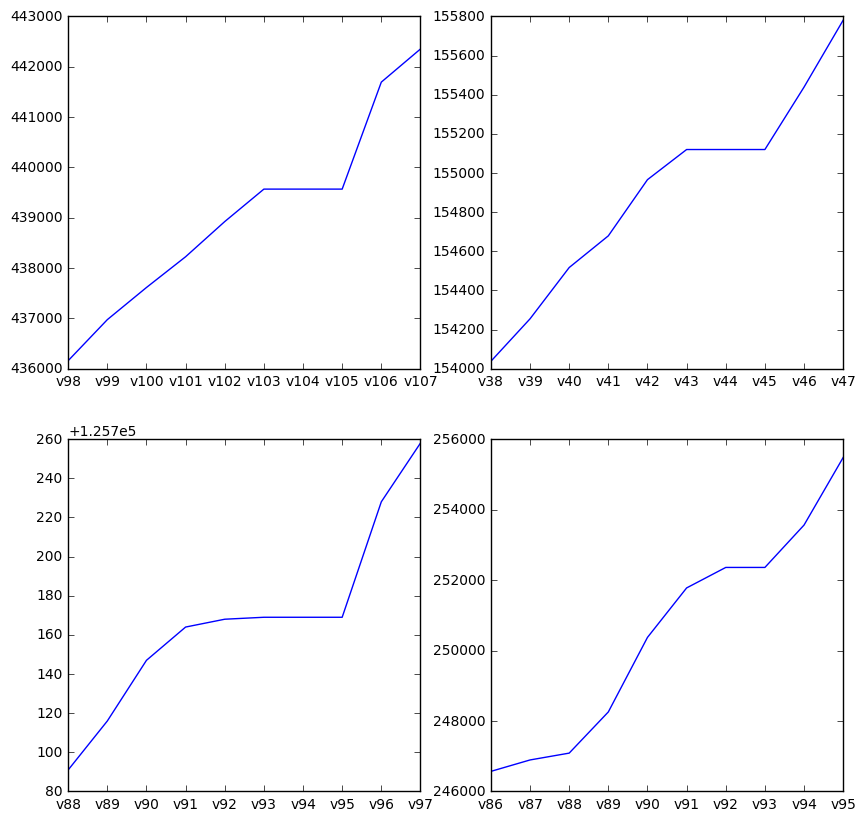

In [14]:
plot_square_size = 2
fig, axs = plt.subplots(plot_square_size,plot_square_size)
plt.figure(figsize=(90, 10))

cases = [29, 338, 545, 392] 
# for random cases use:
# [ random.randint(0, suspicious_indices.shape[0]) for _ in range(plot_square_size*plot_square_size)]

for i in xrange(plot_square_size*plot_square_size):
    row = suspicious_indices[cases[i]][0]
    column = suspicious_indices[cases[i]][1]
    plot_views_neighborhood(dataframe, row, column, radius = 5, ax = axs.flatten()[i])


Four cases have been chosen to ilustrate possible different nature of "zero views" phenomenon. The two top plots look like sudden break in views (especially the left one), for two cases at the bottom views are decreasing to zero to increase again. From these one cannot conclude anything unfortunately, maybe sudden 'zero views' means content is temporarly offline (to be corrected, before posting on social media), or maybe robot was never there. There is no way to guess that without knowledge about views counting mechanism and nature of content itself. One way to go is to **try** to "fix" (if there is anything to fix) 'zero views' taking avg of neighborhood, another way is **not doing it** it. Here (assuming no prior knowledge about the mechanism) I decide not to touch it and move on, later I will have an excuse when my solution turns out not to work well. 

(1) Let's now take a look at basic statistics of v24, v72 and v168. 

In [15]:

# min, max, mean, std, median of v24, v72, v168 
days = [24, 72, 168]
for day in days: 
    min_value = round(dataframe["v" + str(day)].min(),2)
    max_value = round(dataframe["v" + str(day)].max(),2)
    mean_value = round(dataframe["v" + str(day)].mean(),2)
    std_value = round(dataframe["v" + str(day)].std(),2)
    median_value = round(dataframe["v" + str(day)].median(),2)
    print ("min(v("  + str(day) + ")) = " + str(min_value))
    print ("max(v("  + str(day) + ")) = " + str(max_value))
    print ("mean(v(" + str(day) +")) = " + str(mean_value))
    print ("std(v("  + str(day) + ")) = " + str(std_value))
    print ("median(v("  + str(day) + ")) = " + str(median_value))
    print ("\n")


min(v(24)) = 21173.0
max(v(24)) = 15284639.0
mean(v(24)) = 376765.52
std(v(24)) = 923646.74
median(v(24)) = 194357.5


min(v(72)) = 26162.0
max(v(72)) = 22916701.0
mean(v(72)) = 613303.34
std(v(72)) = 1653969.42
median(v(72)) = 237417.5


min(v(168)) = 27139.0
max(v(168)) = 27898237.0
mean(v(168)) = 743209.84
std(v(168)) = 2007963.83
median(v(168)) = 252287.0




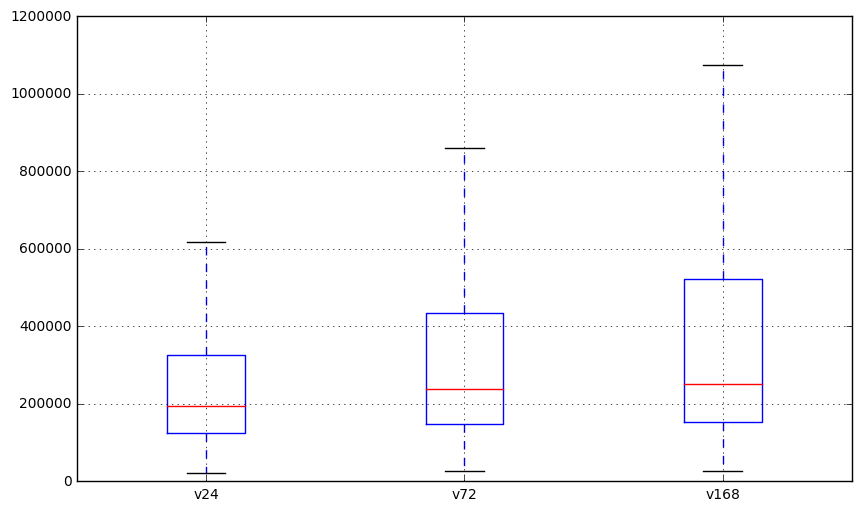

In [16]:
days_to_plot = [dataframe['v24'].values, dataframe['v72'].values, dataframe['v168'].values]
plt.rcParams["figure.figsize"] = (10,6)
dataframe.boxplot(column = ['v24', 'v72', 'v168'], sym='') # sym = '' will prevent boxplot from showing outliers

Outliers are not visible on boxplot above as we supressed them to make a plot visible. Let's take a closer look at histogram of v168. 

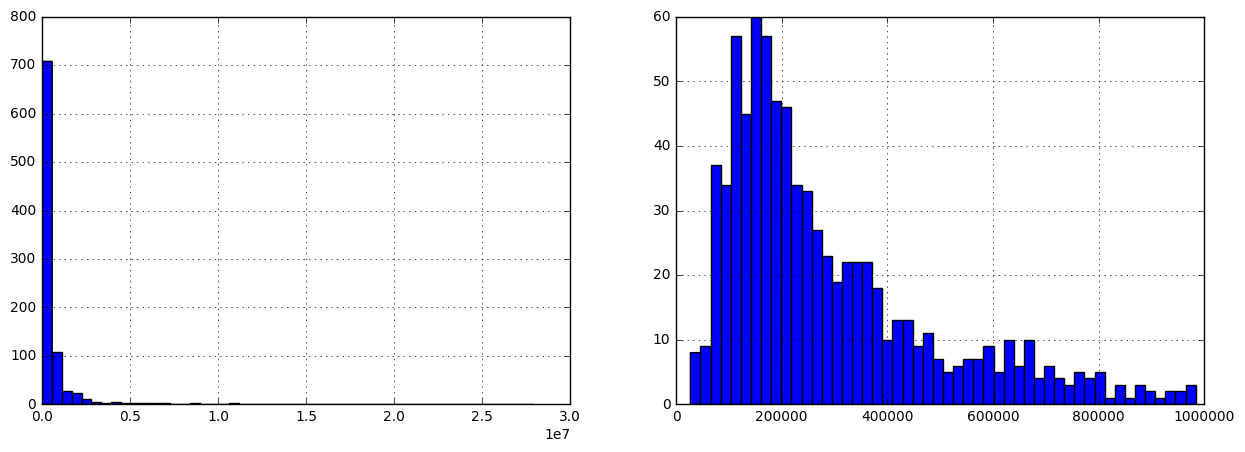

In [18]:
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1,2)
dataframe['v168'].hist(bins = 50, ax = axs[0])
dataframe['v168'][dataframe['v168'].values < 1000000].hist(bins = 50, ax = axs[1])

The distribution of v168 is indeed skewed to the right. Looks like lognormal distribution. 

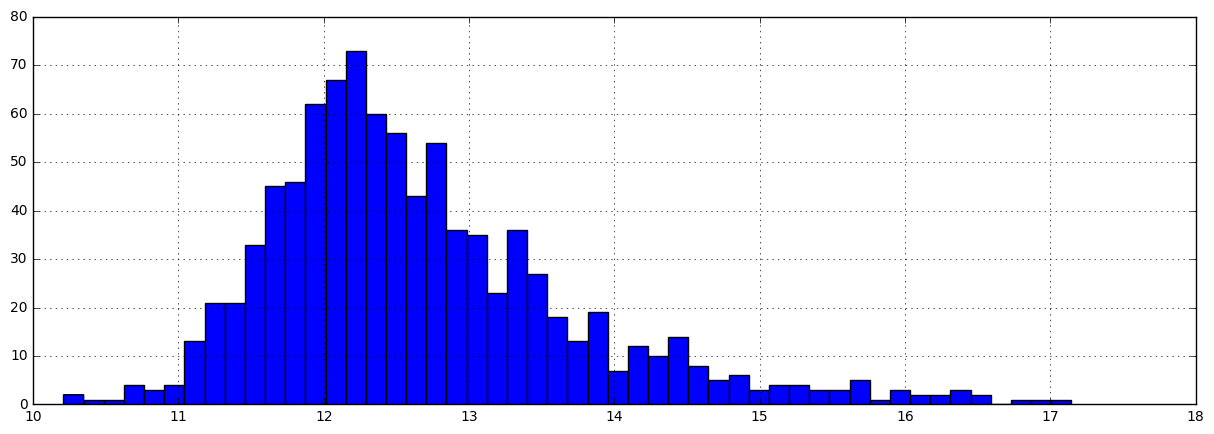

In [19]:
logv168 = np.log(dataframe['v168'])
logv168.hist(bins=50)

Distribution in log domain looks like normal distribution. It is usually the case when dealing with random variables expressing growth. The random variable v168 is assumed to be generated by some initial value multiplied by sequence of growth factors (RV) over time. Therefore in log domain such process turns into addition of several random variables. Central Limit Theorem states that such distribution tends to be normal. 

Let's remove outliers according to 3-sigma rule in log domain. 

In [20]:
max_value = logv168.mean() + 3 * logv168.std()
min_value = logv168.mean() - 3 * logv168.std()

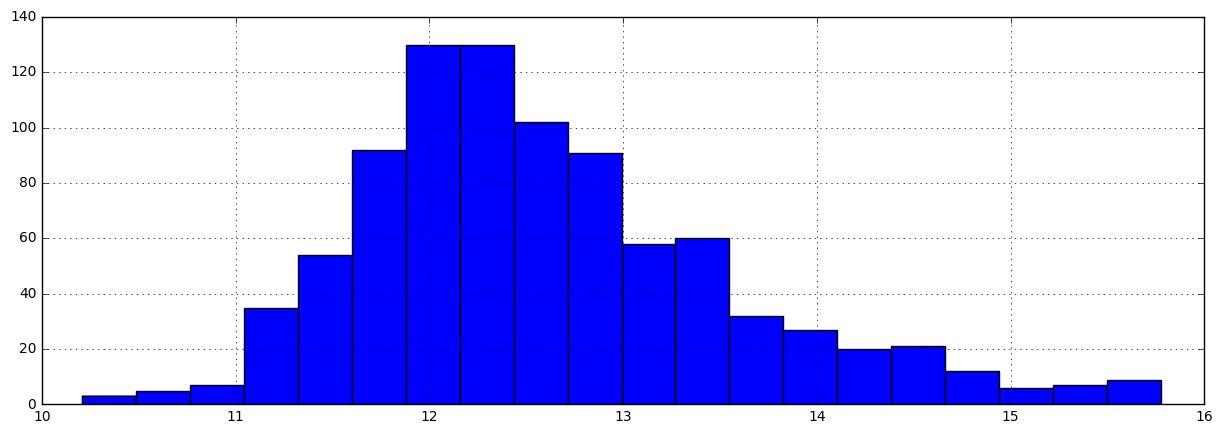

In [21]:
logv168_3sigma = logv168[np.logical_and(logv168 > min_value, logv168 < max_value)]
logv168_3sigma.hist(bins=20)

Lets' remove outliers from our dataset
completely. 

In [22]:
dataframe = dataframe[np.logical_and(logv168 > min_value, logv168 < max_value)]

And take a look at correlation coefficients between log transformed v1,...,v24 and v168 

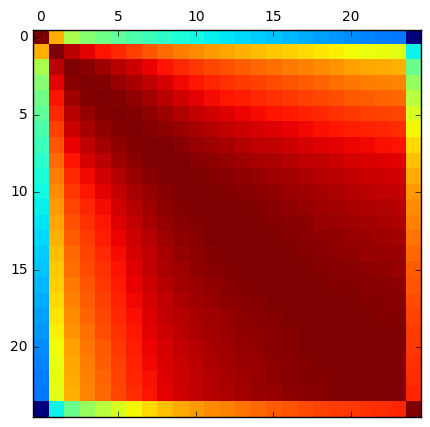

In [30]:
# small close-to-zero value added to prevent nan 
plt.matshow(np.log(dataframe[['v' + str(i) for i in range(1,25) + [168]]] + 0.00001).corr()) 

All variables are extremally correlated with each other (which seems to be quite intuitive). Let's find out the reason why correlation is low between v1 and the rest. 

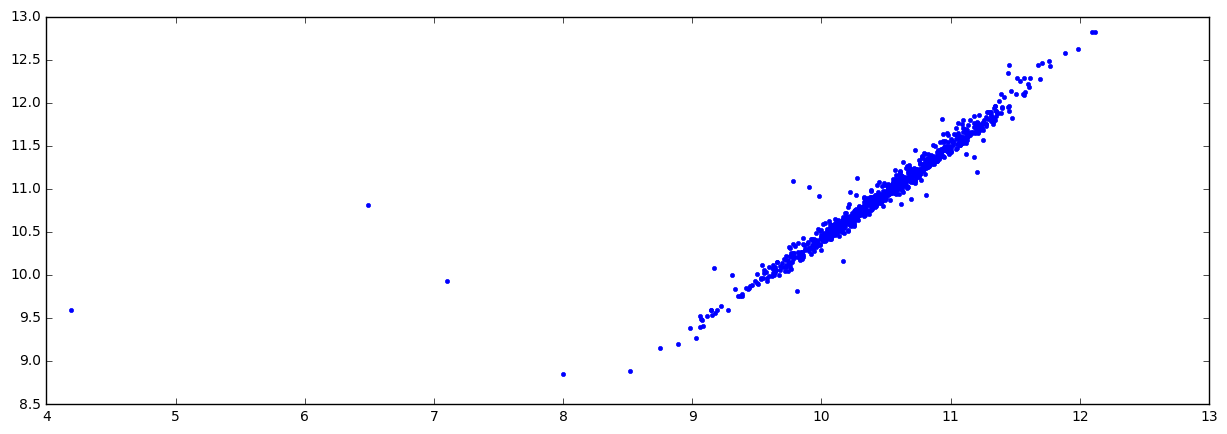

In [31]:
plt.plot(np.log(dataframe[['v1']]+ 0.00001), np.log(dataframe[['v2']]), '.')

Small correlation is the result of v1 being 0 for many cases - it seems unnatural. Let's find out how many cases is affected: 

In [32]:
dataframe[dataframe['v1'] == 0].shape[0]

0

The simplest solution is to exclude these cases from dataset. 

In [33]:
dataframe = dataframe[dataframe['v1'] != 0]

Another approach would be to use median or mean value of v1 or just leave it as zero assuming its natural. 

Lets try to build a linear model to predict number of visits at day 168 based on any previous day n. We are going to have our main code in function 'experiment' - that will take care of random data split, training and computing of mRSE 

In [95]:
from sklearn.linear_model import Ridge, LinearRegression


# LinearRegression.fit uses closed form matrix solution to OLS problem 
# Alternative is to use sklearn.linear_model.Ridge with alpha = 0 and different solver
# but that does not really change the solution on avg 

def fit_linear_model_closed_form(df, targets, predictors, predictors_transform = lambda x:x,  target_transform = lambda x:x):
    lm = LinearRegression()
    lm.fit(predictors_transform(df[predictors].values), target_transform(df[targets].values))
    return lm


from  scipy.stats  import trim_mean
# computes mrse (assumes some transformations of arguments  - identity by default)
def compute_mrse(model, x, y, x_transform = lambda x:x, predicted_y_transform = lambda x:x, y_transform = lambda x:x, proportiontocut = 0.04):
    # here goes the dirty trick 
    return trim_mean(
        (predicted_y_transform(model.predict(x_transform(x))) / y_transform(y) - 1)**2,
        proportiontocut = proportiontocut # some % is truncated - sorry for such disgrace!
    )

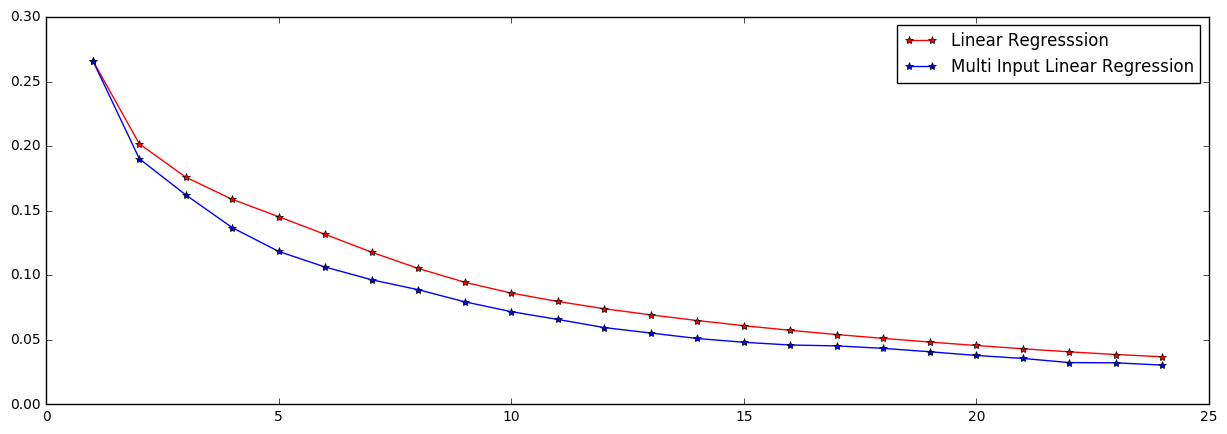

In [179]:
# single experiment, covers training and mRSE computation 

def single_experiment_core(training_dataframe, test_dataframe, truncate_mrse = 0.04):
    # dictionary with linear models (accepting single input variable)
    single_input_lm = dict(
        zip(
            range(1,25), 
            [ 
                fit_linear_model_closed_form(
                    training_dataframe, 
                    ['v168'], 
                    ['v' + str(i)],
                    predictors_transform = np.log,
                    target_transform = np.log
                ) 
                for i in range(1,25) 
            ]
        )
    )
    
    # dictionary with linear models (accepting multi input variable)
    multi_input_lm = dict(
        zip(
            range(1,25), 
            [ 
                fit_linear_model_closed_form(
                    training_dataframe, 
                    ['v168'], 
                    ['v' + str(j) for j in range(1,i + 1)],
                    predictors_transform = np.log,
                    target_transform = np.log
                ) 
                for i in range(1,25) 
            ]
        )
    )

    # mRSE of single input models (computed on test_dataframe)
    mrse_single = [ 
        compute_mrse(
            single_input_lm[i], 
            (test_dataframe[['v' + str(i)]].values), 
            test_dataframe[['v168']].values, 
            x_transform = np.log,
            predicted_y_transform = np.exp,
            proportiontocut = truncate_mrse
        ) 
        for i in range(1,25)
    ]        


    # mRSE of multi input models (computed on test_dataframe)
    mrse_multi = [ 
        compute_mrse(
            multi_input_lm[i], 
            test_dataframe[['v' + str(j) for j in range(1,i+1)]].values,
            test_dataframe[['v168']].values,
            x_transform = np.log,
            predicted_y_transform = np.exp,
            proportiontocut = truncate_mrse
        ) 
        for i in range(1,25)
    ]

    return (mrse_single, mrse_multi, single_input_lm, multi_input_lm)


def single_tooploox_homework_experiment(dataframe, split_ratio = 0.9):
    number_of_training_samples = int(dataframe.shape[0] * split_ratio)
    shuffled_df = dataframe.sample(dataframe.shape[0])
    training_dataframe = shuffled_df[0:number_of_training_samples]
    test_dataframe = shuffled_df[number_of_training_samples:dataframe.shape[0]]

    assert test_dataframe.shape[0] + training_dataframe.shape[0] == dataframe.shape[0] # split correct?
    assert len(set(test_dataframe['id'].values).intersection(set(training_dataframe['id'].values))) == 0 # no overlap? 
    return single_experiment_core(training_dataframe, test_dataframe)

    
mrse_multi_results = []
mrse_single_results = []

# get the results of 300 experiments 
for _ in xrange(300):
    mrse_single, mrse_multi,_,_ = single_tooploox_homework_experiment(dataframe)
    mrse_multi_results.append(mrse_multi)
    mrse_single_results.append(mrse_single)
    
# plot avg results 
plt.plot(range(1,25), np.mean(mrse_single_results,0),'-*', color= 'r'); 
plt.plot(range(1,25), np.mean(mrse_multi_results,0), '-*', color= 'b'); 
plt.legend(['Linear Regresssion', 'Multi Input Linear Regression'])

If we chose not to truncate extreme values when computing mean of mRSE, the plot would have unexpected peaks, unfortunatelly. I really did not know how to handle these. Let's take a look at such single extreme case, though and try to have some thoughts maybe:

In [191]:
training_dataframe = dataframe[0:700]
test_dataframe = dataframe[701::]

In [200]:
# last arg truncated_mrse = 0.0 - we don't use truncated mean here 
mrse_single, mrse_multi, single_input_lm, multi_input_lm = single_experiment_core(training_dataframe, test_dataframe, 0.0)

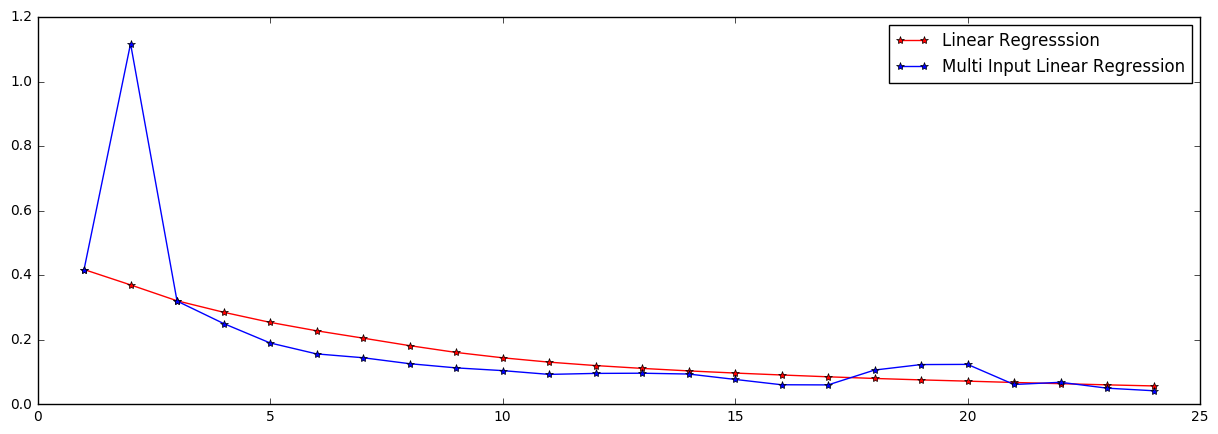

In [218]:
plt.plot(range(1,25), mrse_single,'-*', color= 'r'); 
plt.plot(range(1,25), mrse_multi, '-*', color= 'b'); 
plt.legend(['Linear Regresssion', 'Multi Input Linear Regression'])

Lets take a closer look at problematic case - multi-input linear regression for n = 2 

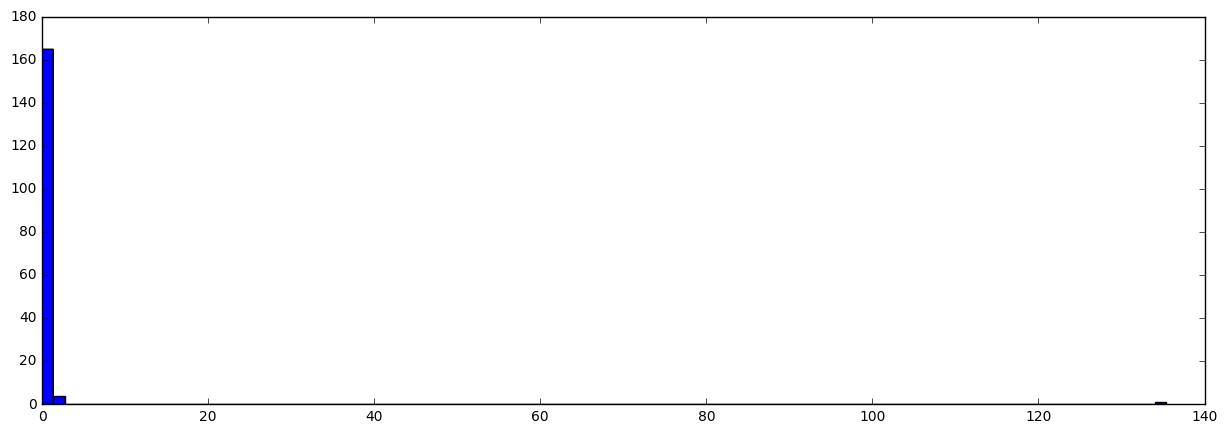

In [231]:
h = plt.hist(
    np.power(
        np.exp(
            multi_input_lm[2].predict(np.log(test_dataframe[['v1','v2']]))
        ) / test_dataframe[['v168']].values - 1,
        2
    ),
    100
)

As we can see there is one extreme case multi-input model is unable to handle: 

In [314]:
problematic_case = np.argmax(
    np.power(
        np.exp(
            multi_input_lm[2].predict(np.log(test_dataframe[['v1','v2']]))
        ) / test_dataframe[['v168']].values - 1,
        2
    )
)

problematic_predicted_value = np.exp(
    multi_input_lm[2].predict(np.log(test_dataframe[['v1','v2']]))
)[problematic_case]

print ("first few values of problematic case = " + str(test_dataframe.values[problematic_case, 1:5]))
print ("predicted values = " + str(problematic_predicted_value[0]))
print ("v168 or problematics case = " + str(dataframe.values[problematic_case, 168]))
print ("v2/v1 = " + str(test_dataframe.values[problematic_case, 2] / test_dataframe.values[problematic_case, 1]))


first few values of problematic case = [659 49559 69071 78869]
predicted values = 2378102.9006
v168 or problematics case = 410059
v2/v1 = 75


Value of v1 is low in comparison to v2 - maybe this post was posted right before midnight ? Lets take a look at the plot of v2/v1 across whole dataset 

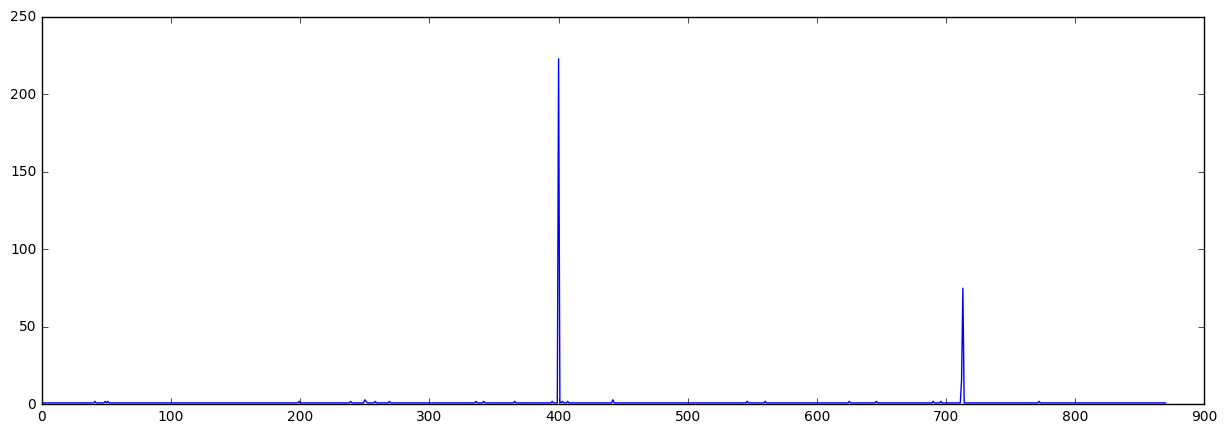

In [315]:
_ = plt.plot((dataframe['v2'].values / dataframe['v1'].values))

Our problematic case is one of the extreme values. It might serve as some explanation for extremely wrong prediction, although I'm not really sure how to handle cases like these in general. I don't believe removing problematic cases post-factum is a solution. In practice I would most probably take a closer look at data collecting mechanism and try to find a reason there. Maybe it has something to do with repeated vies numbers over time for same content. No idea. 

For now it's over, I have to finish here, partially defeated. 